### Configuration

In [115]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier
from lightgbm .sklearn import LGBMClassifier
from xgboost import XGBClassifier

from scipy.stats import randint, loguniform


In [116]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Reading, splitting data

In [117]:
dfs = []
for f in Path("data").iterdir():
    df = pd.read_csv(f)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)    

In [118]:
df_playoff = pd.read_csv("playoff.csv")
df = df.merge(
    df_playoff,
    on=["team", "season"],
    how="left"
)

In [119]:
df.to_csv("raw_data.csv", index=False) # keeping raw data as a separate file, a fallback

In [120]:
df = df[df["situation"] == "all"] # only using combined metric(5v5 + 4v5 + 5v4...) for predictions
df.shape

(554, 110)

In [121]:
df_train, df_test = train_test_split(df, random_state=67)

### EDA

In [122]:
df_train.head()

,team,season,name,team.1,position,situation,games_played,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,penalitiesFor,penalitiesAgainst,playoff
1811,MTL,2019,MTL,MTL,Team Level,all,71,0.53,0.53,0.52,258596.0,2386.76,223.07,163.00,558.60,78.11,1309.56,969.79,213.98,224.14,215.04,2424.0,880.0,1148.0,4452.0,208.0,188.0,34.0,532.0,106.0,1053.0,1217.0,2216.0,3096.0,229.0,490.0,2140.0,1882.0,489.0,874.0,2434.0,626.0,244.0,64.85,77.88,80.34,66.0,67.0,75.0,4475.95,3304.0,3322.10,676.0,35.76,39.18,39.18,219.52,220.49,215.66,2142.02,201.00,150.35,501.51,71.42,1196.33,869.51,193.64,201.39,193.99,2210.0,782.0,928.0,3920.0,220.0,162.0,31.0,520.0,72.0,945.0,1073.0,1990.0,2772.0,205.0,442.0,2104.0,1693.0,531.0,911.0,2229.0,564.0,199.0,61.68,70.37,68.95,69.0,86.0,65.0,3920.91,2992.0,2993.71,686.0,33.29,31.16,31.21,202.96,203.28,198.78,NaN,NaN,0
2231,MIN,2022,MIN,MIN,Team Level,all,82,0.51,0.50,0.51,301108.0,2614.25,258.75,181.28,591.90,85.41,1428.64,1061.03,246.01,260.21,247.45,2535.0,1072.0,1187.0,4794.0,239.0,245.0,35.0,533.0,74.0,1159.0,1357.0,2296.0,3368.0,336.0,781.0,2181.0,1784.0,541.0,533.0,2572.0,775.0,260.0,73.51,94.96,90.27,60.0,98.0,81.0,4829.45,3607.0,3632.57,269.0,40.65,49.90,49.90,249.50,250.89,242.84,2532.86,248.36,173.68,585.17,84.28,1401.06,1008.46,235.35,247.30,234.40,2552.0,949.0,1318.0,4819.0,219.0,225.0,27.0,480.0,98.0,1128.0,1351.0,2333.0,3282.0,336.0,790.0,2393.0,1638.0,475.0,590.0,2535.0,720.0,246.0,74.37,86.14,87.86,69.0,84.0,66.0,4792.63,3501.0,3488.72,327.0,38.38,47.43,47.53,239.21,238.53,231.07,NaN,NaN,1
1046,OTT,2014,OTT,OTT,Team Level,all,82,0.52,0.51,0.50,301584.0,2523.50,225.45,168.13,582.83,81.27,1399.27,1056.04,217.68,225.92,218.15,2540.0,973.0,1300.0,4813.0,232.0,176.0,40.0,521.0,76.0,1134.0,1374.0,2308.0,3281.0,325.0,759.0,2421.0,2279.0,648.0,719.0,2691.0,606.0,216.0,73.86,72.94,78.64,69.0,76.0,87.0,4

In [123]:
df_train.shape

(415, 110)

In [124]:
df_train.head()

,team,season,name,team.1,position,situation,games_played,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,penalitiesFor,penalitiesAgainst,playoff
1811,MTL,2019,MTL,MTL,Team Level,all,71,0.53,0.53,0.52,258596.0,2386.76,223.07,163.00,558.60,78.11,1309.56,969.79,213.98,224.14,215.04,2424.0,880.0,1148.0,4452.0,208.0,188.0,34.0,532.0,106.0,1053.0,1217.0,2216.0,3096.0,229.0,490.0,2140.0,1882.0,489.0,874.0,2434.0,626.0,244.0,64.85,77.88,80.34,66.0,67.0,75.0,4475.95,3304.0,3322.10,676.0,35.76,39.18,39.18,219.52,220.49,215.66,2142.02,201.00,150.35,501.51,71.42,1196.33,869.51,193.64,201.39,193.99,2210.0,782.0,928.0,3920.0,220.0,162.0,31.0,520.0,72.0,945.0,1073.0,1990.0,2772.0,205.0,442.0,2104.0,1693.0,531.0,911.0,2229.0,564.0,199.0,61.68,70.37,68.95,69.0,86.0,65.0,3920.91,2992.0,2993.71,686.0,33.29,31.16,31.21,202.96,203.28,198.78,NaN,NaN,0
2231,MIN,2022,MIN,MIN,Team Level,all,82,0.51,0.50,0.51,301108.0,2614.25,258.75,181.28,591.90,85.41,1428.64,1061.03,246.01,260.21,247.45,2535.0,1072.0,1187.0,4794.0,239.0,245.0,35.0,533.0,74.0,1159.0,1357.0,2296.0,3368.0,336.0,781.0,2181.0,1784.0,541.0,533.0,2572.0,775.0,260.0,73.51,94.96,90.27,60.0,98.0,81.0,4829.45,3607.0,3632.57,269.0,40.65,49.90,49.90,249.50,250.89,242.84,2532.86,248.36,173.68,585.17,84.28,1401.06,1008.46,235.35,247.30,234.40,2552.0,949.0,1318.0,4819.0,219.0,225.0,27.0,480.0,98.0,1128.0,1351.0,2333.0,3282.0,336.0,790.0,2393.0,1638.0,475.0,590.0,2535.0,720.0,246.0,74.37,86.14,87.86,69.0,84.0,66.0,4792.63,3501.0,3488.72,327.0,38.38,47.43,47.53,239.21,238.53,231.07,NaN,NaN,1
1046,OTT,2014,OTT,OTT,Team Level,all,82,0.52,0.51,0.50,301584.0,2523.50,225.45,168.13,582.83,81.27,1399.27,1056.04,217.68,225.92,218.15,2540.0,973.0,1300.0,4813.0,232.0,176.0,40.0,521.0,76.0,1134.0,1374.0,2308.0,3281.0,325.0,759.0,2421.0,2279.0,648.0,719.0,2691.0,606.0,216.0,73.86,72.94,78.64,69.0,76.0,87.0,4

In [125]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 415 entries, 1811 to 2266
Columns: 110 entries, team to playoff
dtypes: float64(102), int64(3), object(5)
memory usage: 359.9+ KB


In [126]:
df.select_dtypes(include=["object"]).columns.tolist()

['team', 'name', 'team.1', 'position', 'situation']

In [127]:
df.select_dtypes(include=["int64"]).columns.tolist()

['season', 'games_played', 'playoff']

In [128]:
with pd.option_context('display.max_rows', None):
    print(df_train.isna().any())

team                                         False
season                                       False
name                                         False
team.1                                       False
position                                     False
situation                                    False
games_played                                 False
xGoalsPercentage                             False
corsiPercentage                              False
fenwickPercentage                            False
iceTime                                      False
xOnGoalFor                                   False
xGoalsFor                                    False
xReboundsFor                                 False
xFreezeFor                                   False
xPlayStoppedFor                              False
xPlayContinuedInZoneFor                      False
xPlayContinuedOutsideZoneFor                 False
flurryAdjustedxGoalsFor                      False
scoreVenueAdjustedxGoalsFor    

In [129]:
with pd.option_context('display.max_rows', None):
    print(df_train.isnull().sum())

team                                           0
season                                         0
name                                           0
team.1                                         0
position                                       0
situation                                      0
games_played                                   0
xGoalsPercentage                               0
corsiPercentage                                0
fenwickPercentage                              0
iceTime                                        0
xOnGoalFor                                     0
xGoalsFor                                      0
xReboundsFor                                   0
xFreezeFor                                     0
xPlayStoppedFor                                0
xPlayContinuedInZoneFor                        0
xPlayContinuedOutsideZoneFor                   0
flurryAdjustedxGoalsFor                        0
scoreVenueAdjustedxGoalsFor                    0
flurryScoreVenueAdju

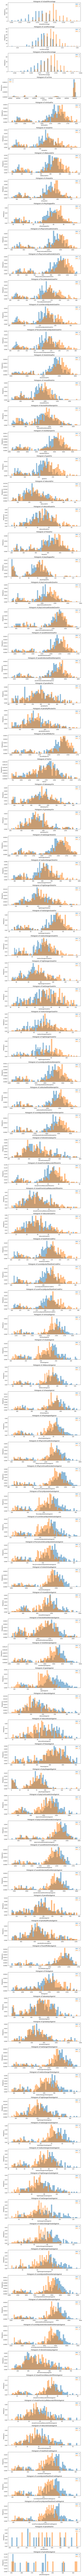

In [ ]:
# this is without games_played normalization
cols_to_plot = df_train.select_dtypes(include=["float64"]).columns.tolist()
fig, axes = plt.subplots(nrows=len(cols_to_plot), ncols=1, figsize=(10, 3*len(cols_to_plot)))

for i, c in enumerate(cols_to_plot):
    df_train.groupby("playoff")[c].plot.hist(
        bins=50,
        alpha=0.5, 
        legend=True, 
        density=True, 
        ax=axes[i]
    )
    
    axes[i].set_title(f"Histogram of {c}")
    axes[i].set_xlabel(c)

plt.tight_layout()
plt.show()


In [131]:
df_train[["xFreezeFor", "xPlayStoppedFor", "xPlayContinuedInZoneFor", "playoff"]].corr() 

,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,playoff
xFreezeFor,1.000000,0.994001,0.976669,0.112922
xPlayStoppedFor,0.994001,1.000000,0.986277,0.125181
xPlayContinuedInZoneFor,0.976669,0.986277,1.000000,0.133454
playoff,0.112922,0.125181,0.133454,1.000000


lets just include one of these...i'll choose xPlayContinuedInZoneFor because highest correlation with playoff (albeit minimally, should not read too much into it). as an extension i'll also use the other xPlayContinued(In/Outside)Zone(For/Against)
<br>
<br>

In [132]:
df_train[["xGoalsPercentage", "flurryScoreVenueAdjustedxGoalsFor", "playoff"]].corr()

,xGoalsPercentage,flurryScoreVenueAdjustedxGoalsFor,playoff
xGoalsPercentage,1.000000,0.343666,0.610125
flurryScoreVenueAdjustedxGoalsFor,0.343666,1.000000,0.197803
playoff,0.610125,0.197803,1.000000


In [133]:
df_train[["corsiPercentage", "fenwickPercentage", "xOnGoalFor", "playoff"]].corr()

,corsiPercentage,fenwickPercentage,xOnGoalFor,playoff
corsiPercentage,1.000000,0.964455,0.333351,0.434631
fenwickPercentage,0.964455,1.000000,0.318613,0.476752
xOnGoalFor,0.333351,0.318613,1.000000,0.130911
playoff,0.434631,0.476752,0.130911,1.000000


hmm... just fenwick or both? my gut is saying try out with both first so i'll do that. i wanna learn more systematic/data driven approaches to make these decisions rather than just my gut...
<br>
<br>

In [134]:
df_train[df_train["season"] == 2025][["xGoalsPercentage", 
                                      "xGoalsFor", 
                                      "xOnGoalFor", 
                                      "xPlayContinuedInZoneFor",
                                      "xPlayContinuedOutsideZoneFor",
                                      "xPlayContinuedInZoneAgainst",
                                      "xPlayContinuedOutsideZoneAgainst",
                                      "flurryScoreVenueAdjustedxGoalsFor",
                                      "lowDangerxGoalsFor",
                                      "mediumDangerxGoalsFor"]].head()

,xGoalsPercentage,xGoalsFor,xOnGoalFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryScoreVenueAdjustedxGoalsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor
2626,0.51,119.59,1271.80,686.13,496.12,637.67,472.58,112.91,36.78,37.11
2621,0.51,132.41,1310.37,702.01,511.82,700.09,500.51,126.21,40.74,41.35
2631,0.51,129.45,1357.50,733.88,522.22,644.06,462.66,124.77,40.97,43.64
2611,0.48,128.02,1312.02,710.66,504.20,706.48,502.84,121.41,39.56,43.13
2616,0.46,123.33,1324.86,727.08,512.48,758.93,542.46,119.39,37.16,42.03


In [135]:
df_train[df_train["season"] != 2025][["xGoalsPercentage", 
                                      "xGoalsFor", 
                                      "xOnGoalFor", 
                                      "xPlayContinuedInZoneFor",
                                      "xPlayContinuedOutsideZoneFor",
                                      "xPlayContinuedInZoneAgainst",
                                      "xPlayContinuedOutsideZoneAgainst",
                                      "flurryScoreVenueAdjustedxGoalsFor",
                                      "lowDangerxGoalsFor",
                                      "mediumDangerxGoalsFor"]].head()

,xGoalsPercentage,xGoalsFor,xOnGoalFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryScoreVenueAdjustedxGoalsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor
1811,0.53,223.07,2386.76,1309.56,969.79,1196.33,869.51,215.04,64.85,77.88
2231,0.51,258.75,2614.25,1428.64,1061.03,1401.06,1008.46,247.45,73.51,94.96
1046,0.52,225.45,2523.50,1399.27,1056.04,1436.51,1077.43,218.15,73.86,72.94
1146,0.51,254.52,2658.51,1486.16,1075.64,1405.96,1040.10,242.32,77.98,89.48
1076,0.48,222.66,2560.21,1418.25,1057.18,1406.15,1055.73,215.47,75.57,79.84


mhm all but goals percentage (and ofc corsi & fenwick) need adjusting (i will NOT be using xGoalsFor as xGoalsPercentage is derived from it)
<br>
<br>

#### preprocessing/feature engineering

we want features that can be used regardless of games played. only 3 in the current dataset fit this description ("xGoalsPercentage", "corsiPercentage", "fenwickPercentage"). we'll create some more ratios/percentages using relevant features and the EDA done above

-> these initial relevant features were identified by using histograms and corr(). some decisions were also made with my (limited) domain knowledge/gut instinct

features i chose in eda above:
- corsiPercentage
- fenwickPercentage
- xGoalsPercentage
- xOnGoalFor
- xPlayContinuedInZoneFor
- xPlayContinuedOutsideZoneFor
- xPlayContinuedInZoneAgainst
- xPlayContinuedOutsideZoneAgainst
- flurryScoreVenueAdjustedxGoalsFor
- lowDangerShotsFor
- lowDangerxGoalsFor
- lowDangerGoalsFor
- lowDangerShotsAgainst
- lowDangerxGoalsAgainst
- lowDangerGoalsAgainst